In [1]:
%pylab notebook
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/")

### A

In [3]:
from zillow import features,config
reload (features)

<module 'zillow.features' from '../python/zillow/features.pyc'>

In [4]:
def read_error(state,year):
    fname=os.path.join(config.get_state_year_folder2(state,year),'lgbchain_prediction_merged.parq')
    #y=features.get('sale_price_zip5',state,year)
    lati=features.get('longi_lati',state,year)
    month=features.get('month',state,year)
    df=pd.concat([dd.read_parquet(fname)['error'].compute(),lati,month],axis=1).dropna()
    df['year']=(df['month']/100).astype(np.int32)
    df['month']=(df['month']-df['year']*100).astype(np.int32)
    df['abserror']=df['error'].abs()
    return df

In [5]:
def read_state_error(state):
    return pd.concat([read_error(state,year) for year in config.YEARS],0)
        


In [6]:
df = read_state_error('39')

In [7]:
df.shape

(639536, 6)

In [8]:
df[['year','error','abserror']].groupby('year').aggregate(['mean','std','median','count'])

error                             abserror                           
          mean       std    median  count      mean       std    median  count
year                                                                          
2007  0.060575  0.428305  0.000131  60578  0.239204  0.360409  0.113112  60578
2008  0.062784  0.435968 -0.000459  46307  0.250082  0.362584  0.119113  46307
2009  0.056251  0.411336 -0.001038  41595  0.238770  0.339631  0.118657  41595
2010  0.050727  0.408759 -0.000818  40221  0.238527  0.335798  0.120077  40221
2011  0.052695  0.419996 -0.001047  37941  0.250075  0.341517  0.129801  37941
2012  0.051723  0.488086  0.000019  44902  0.269810  0.410006  0.130215  44902
2013  0.045309  0.448184  0.000147  58774  0.248059  0.376015  0.119312  58774
2014  0.048745  0.406310 -0.000640  59117  0.220129  0.344973  0.104770  59117
2015  0.044192  0.389181  0.000052  65225  0.207543  0.332175  0.097815  65225
2016  0.029926  0.419329  0.000237  71249  0.210946  0.363639  0.099869  71249
2017  0.025636  0.454962 -0.000048  85891  0.222692  0.397562  0.098005  85891
2018  0.033783  0.446584  0.001661  27736  0.233119  0.382403  0.104924  27736

In [12]:
grouped=pd.pivot_table(df,columns='month',index=['year'],values=['error'],aggfunc='median')
grouped

error                                                              \
month        1         2         3         4         5         6         7    
year                                                                          
2007  -0.004418 -0.006184 -0.004392  0.005465  0.007837  0.006704  0.001162   
2008   0.000941  0.004556  0.003856  0.007057  0.008237  0.005841 -0.002178   
2009  -0.002623 -0.018400 -0.003969  0.000588  0.012331  0.004730  0.008095   
2010  -0.000180  0.010354 -0.000395  0.000068  0.006240 -0.003436 -0.003892   
2011  -0.010122 -0.011407 -0.036409 -0.016868 -0.002784  0.002822  0.012488   
2012  -0.013934 -0.015778 -0.016331  0.002603  0.009129  0.014151  0.009084   
2013  -0.017614 -0.002830 -0.005642  0.004079  0.008519  0.010010  0.006189   
2014  -0.006509 -0.003182 -0.003560  0.001372 -0.001568  0.004618 -0.003753   
2015  -0.009605 -0.004910 -0.002149  0.001129  0.004044  0.012090  0.002450   
2016  -0.008214 -0.002798 -0.000068  0.000829  0.001768  0.005433 -0.001463   
2017  -0.011053 -0.006476  0.001547  0.005958  0.006374 -0.001398  0.002342   
2018   0.007638  0.001214  0.003273 -0.005329  0.001880 -0.023142       NaN   

                                                         
month        8         9         10        11        12  
year                                                     
2007   0.001466  0.000770 -0.000086 -0.006841 -0.017344  
2008   0.000604 -0.014282 -0.007950 -0.011010 -0.016241  
2009  -0.000137  0.000934 -0.010857  0.002230 -0.020351  
2010  -0.002399 -0.008035  0.009473  0.002463 -0.020537  
2011   0.003975  0.013424 -0.000660  0.013914  0.005615  
2012   0.008322  0.006685 -0.006076 -0.008209 -0.017815  
2013   0.007363  0.000914 -0.013176 -0.010387 -0.017522  
2014   0.001455 -0.005830  0.002903  0.002611 -0.001096  
2015  -0.006326 -0.001860 -0.002904 -0.003634 -0.003237  
2016   0.003641 -0.000524 -0.003894  0.000286 -0.000817  
2017   0.002106  0.001961 -0.005055 -0.002569 -0.004109  
2018        NaN       NaN       NaN       NaN       NaN

In [13]:
grouped.T.corr()

year      2007      2008      2009      2010      2011      2012      2013  \
year                                                                         
2007  1.000000  0.618824  0.766584  0.430553 -0.014173  0.835571  0.799519   
2008  0.618824  1.000000  0.370390  0.528390 -0.596020  0.265495  0.556472   
2009  0.766584  0.370390  1.000000  0.145187  0.204668  0.771362  0.659996   
2010  0.430553  0.528390  0.145187  1.000000 -0.303198  0.008375  0.139708   
2011 -0.014173 -0.596020  0.204668 -0.303198  1.000000  0.442900  0.103602   
2012  0.835571  0.265495  0.771362  0.008375  0.442900  1.000000  0.856817   
2013  0.799519  0.556472  0.659996  0.139708  0.103602  0.856817  1.000000   
2014  0.242115  0.076520  0.063419  0.144815  0.183940  0.303618  0.213308   
2015  0.585812  0.338500  0.499940 -0.052121  0.128189  0.659565  0.661256   
2016  0.427173  0.225894  0.402196 -0.181215  0.161747  0.629274  0.733726   
2017  0.590954  0.280720  0.612277 -0.061865 -0.008102  0.642658  0.752353   
2018 -0.600005 -0.411954 -0.288198  0.466271 -0.496587 -0.735847 -0.706383   

year      2014      2015      2016      2017      2018  
year                                                    
2007  0.242115  0.585812  0.427173  0.590954 -0.600005  
2008  0.076520  0.338500  0.225894  0.280720 -0.411954  
2009  0.063419  0.499940  0.402196  0.612277 -0.288198  
2010  0.144815 -0.052121 -0.181215 -0.061865  0.466271  
2011  0.183940  0.128189  0.161747 -0.008102 -0.496587  
2012  0.303618  0.659565  0.629274  0.642658 -0.735847  
2013  0.213308  0.661256  0.733726  0.752353 -0.706383  
2014  1.000000  0.443267  0.597632  0.163327 -0.939855  
2015  0.443267  1.000000  0.670511  0.507232 -0.876240  
2016  0.597632  0.670511  1.000000  0.681009 -0.789100  
2017  0.163327  0.507232  0.681009  1.000000 -0.227970  
2018 -0.939855 -0.876240 -0.789100 -0.227970  1.000000

<IPython.core.display.Javascript object>


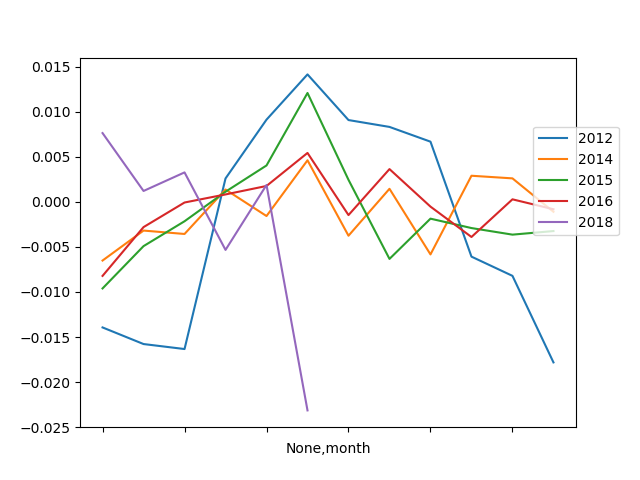

In [17]:
grouped.T[[2012,2014,2015,2016,2018]].plot()
plt.legend(loc='lower center', bbox_to_anchor=(1.0, 0.5))

In [9]:
grouped=df[df.year==2018][['month','error','abserror']].groupby('month').aggregate(['mean','std','median','count'])
grouped

error                            abserror                          
           mean       std    median count      mean       std    median count
month                                                                        
1      0.047782  0.477640  0.007638  4975  0.249681  0.409964  0.113985  4975
2      0.036015  0.467402  0.001214  4442  0.255914  0.392754  0.116070  4442
3      0.032984  0.451089  0.003273  6629  0.236869  0.385298  0.105437  6629
4      0.014260  0.432488 -0.005329  5982  0.226428  0.368743  0.102595  5982
5      0.043641  0.410508  0.001880  5569  0.204022  0.358872  0.094324  5569
6     -0.055204  0.338332 -0.023142   139  0.186847  0.287007  0.096946   139

In [10]:
grouped=df[df.year<2018][['month','error','abserror']].groupby('month').aggregate(['mean','std','median','count'])
grouped

error                             abserror                      \
           mean       std    median  count      mean       std    median   
month                                                                      
1      0.052209  0.457319 -0.007863  33315  0.251702  0.385370  0.118192   
2      0.058171  0.459154 -0.004724  31962  0.254486  0.386576  0.119736   
3      0.051614  0.431556 -0.003745  44015  0.237202  0.364195  0.111437   
4      0.052083  0.413794  0.001937  49728  0.226806  0.349995  0.106731   
5      0.046891  0.421200  0.005111  58811  0.219700  0.362407  0.102157   
6      0.041862  0.414692  0.005229  68076  0.214727  0.357230  0.099095   
7      0.043781  0.418413  0.002195  63871  0.220981  0.357984  0.103721   
8      0.041966  0.407541  0.001801  62938  0.220327  0.345407  0.106278   
9      0.045623  0.425879 -0.000934  55322  0.232317  0.359836  0.112313   
10     0.043401  0.440691 -0.003988  54377  0.244196  0.369404  0.117856   
11     0.045253  0.445968 -0.001812  45464  0.249150  0.372637  0.121528   
12     0.036272  0.454075 -0.008810  43921  0.256594  0.376375  0.126056   

              
       count  
month         
1      33315  
2      31962  
3      44015  
4      49728  
5      58811  
6      68076  
7      63871  
8      62938  
9      55322  
10     54377  
11     45464  
12     43921

<IPython.core.display.Javascript object>


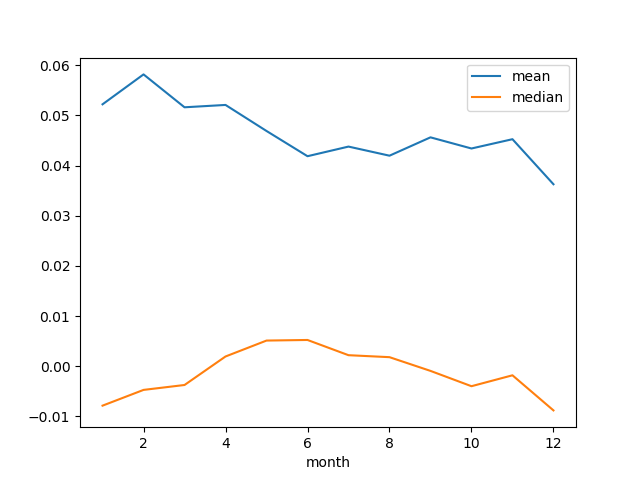

In [11]:
grouped['error'][['mean','median']].plot();

<IPython.core.display.Javascript object>


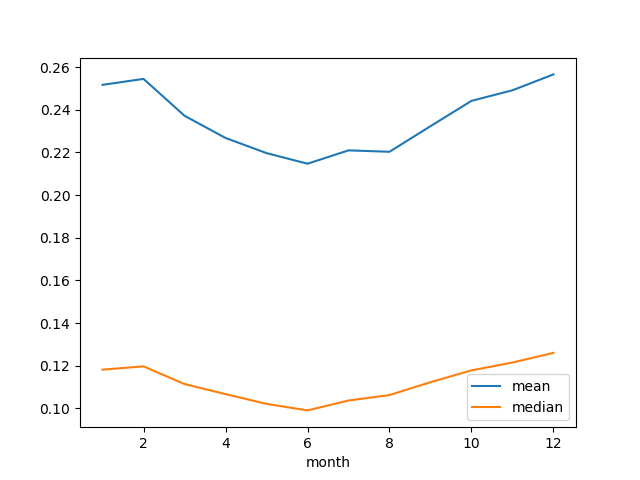

In [12]:
grouped['abserror'][['mean','median']].plot();

In [13]:
df.head()

error  longitude   latitude  month  year  abserror
parcelid                                                       
85228618 -0.014180 -81.766991  41.490433      3  2007  0.014180
85228694 -0.095912 -81.761261  41.488487      7  2007  0.095912
85228699  0.077816 -81.762825  41.488605      8  2007  0.077816
85228763  0.085954 -81.755501  41.486851      8  2007  0.085954
85228829  1.453998 -81.746475  41.481647      7  2007  1.453998

In [14]:
def plot3d(subdf,col):
    import os
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata


    fig = plt.figure()
    ax = Axes3D(fig)
    # my_data = np.genfromtxt('2014_0.01_v3_HDF5.txt', delimiter = ',',     skip_header = 1)
    # my_data[my_data==0] = np.nan 
    # my_data = my_data[~np.isnan(my_data).any(axis=1)]
    X = subdf.longitude.values
    Y = subdf.latitude.values
    Z = subdf[col].values
    xi = np.linspace(X.min(),X.max(),(len(Z)/3))
    yi = np.linspace(Y.min(),Y.max(),(len(Z)/3))
    zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='nearest')

    xig, yig = np.meshgrid(xi, yi)

    surf = ax.plot_surface(xig, yig, zi, cmap='gist_earth')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('error ')
    #ax.set_zlim3d(Z.min(),Z.max())

In [15]:
subdf=df.iloc[np.random.permutation(range(len(df)))[:2000]]

In [16]:
subdf=df[df.year==2018]
subdf=df.iloc[np.random.permutation(range(len(subdf)))[:2000]]

<IPython.core.display.Javascript object>


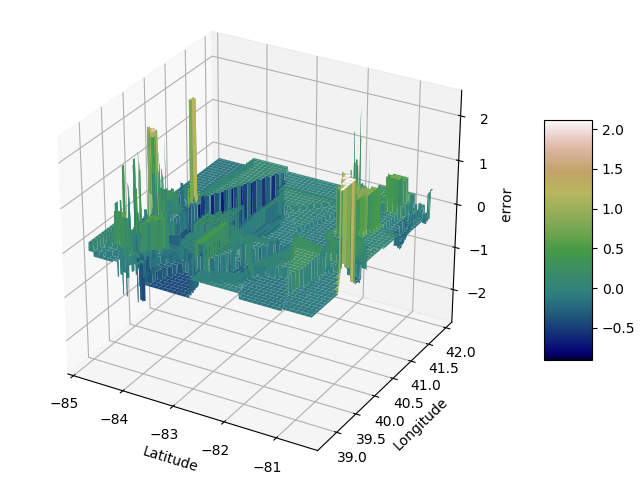

In [17]:
plot3d(subdf,'error')

<IPython.core.display.Javascript object>


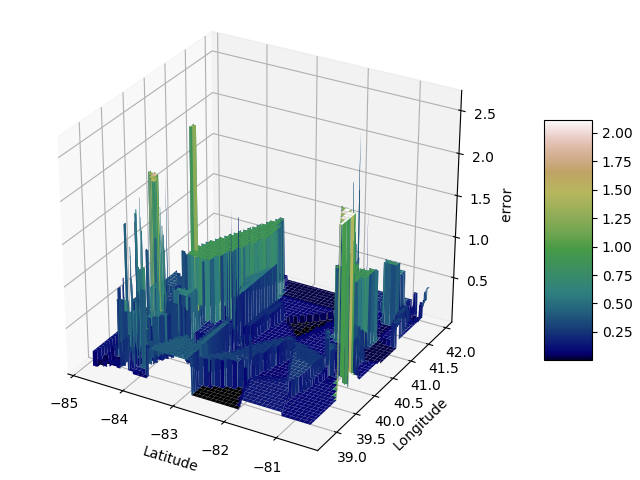

In [18]:
plot3d(subdf,'abserror')

In [19]:
subdf=df[df.year==2017]
subdf=df.iloc[np.random.permutation(range(len(subdf)))[:2000]]

<IPython.core.display.Javascript object>


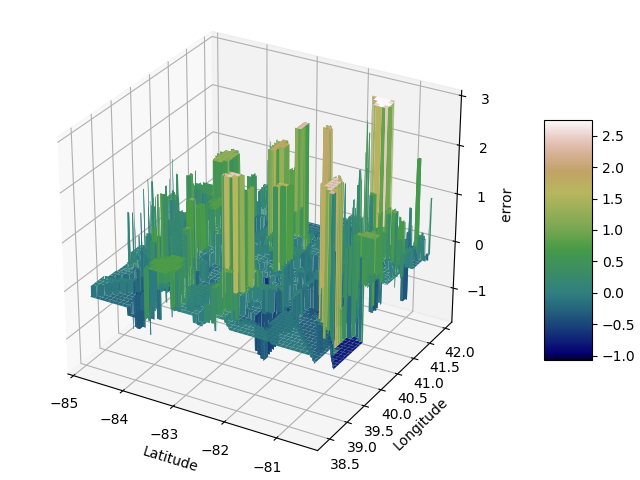

In [20]:
plot3d(subdf,'error')

<IPython.core.display.Javascript object>


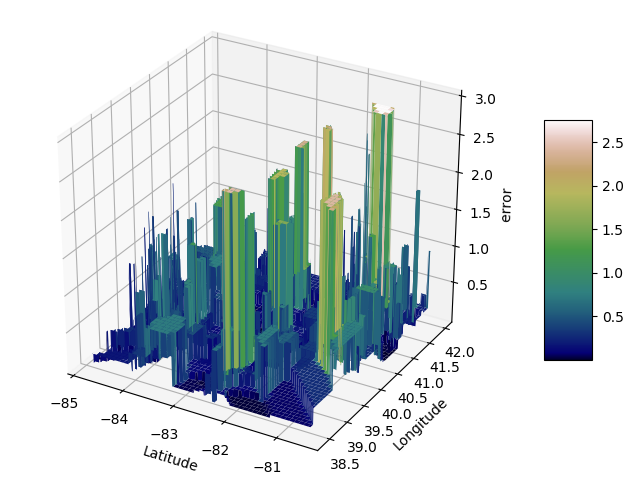

In [21]:
plot3d(subdf,'abserror')